## Latent space are responsibilities, that is, probability of being assigned to given cluster

In [248]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from vae_lib.utils.gmm_on_circle import MixtureOfNormalsOnCircle
from vae_lib.utils.gmm_mixture_for_discrete_vae import GmmMixtureForDiscreteVae
from sklearn.utils.extmath import softmax

In [249]:
Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

### Utility functions

In [250]:
def permute(X, y=None):
    n_all_cases = X.shape[0]
    perm = np.arange(n_all_cases)
    np.random.shuffle(perm)
    if y is not None:
        return X[perm], y[perm]
    else:
        return X[perm], None

In [251]:
def plot_latent_space(model, onehot_encoder, X, y):
    m, sd = model.encode2(X)
    m_flat = m.reshape(-1)
    sd_flat = sd.reshape(-1)
    y_decoded = onehot_encoder.inverse_transform(y).reshape(-1)
    plt.figure(figsize=(10, 10))
    plt.scatter(m_flat, sd_flat, c=y_decoded, cmap='brg')
    plt.colorbar()
    plt.show()

In [252]:
def plot_2d_latent_space(model, onehot_encoder, X, y):
    m_1, sd_1, m_2, sd_2 = model_supervised.encode2(X_test)
    y_decoded = onehot_encoder.inverse_transform(y_test).reshape(-1)
    fig = plt.figure(figsize=(20, 20))


    plt.subplot(2, 2, 1)
    plt.scatter(m_1[:,0], m_1[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.scatter(m_2[:,0], m_2[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

#     plt.subplot(2, 2, 3)
#     plt.scatter(m[:,0], sd[:,0], c=y_decoded, cmap='brg')
#     plt.colorbar()

    print(sd_1)
    Z_1 = np.random.normal(m_1,sd_1)
    plt.subplot(2, 2, 3)
    plt.scatter(Z_1[:,0], Z_1[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()
    
    print(sd_2)
    Z_2 = np.random.normal(m_2,sd_2)
    plt.subplot(2, 2, 4)
    plt.scatter(Z_2[:,0], Z_2[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.show()

In [417]:
def plot_2d_latent_space(model, onehot_encoder, X, y):
    predictions = model_supervised.encode2(X_test)
    y_decoded = onehot_encoder.inverse_transform(y_test).reshape(-1)
    fig = plt.figure(figsize=(20, 20))
    
    def create_subplot(i, prediction):
        m, _ = np.split(prediction, indices_or_sections=2, axis=1)
        plt.subplot(3, 2, i)
        plt.scatter(m[:,0], m[:,1], c=y_decoded, cmap='brg')
        plt.colorbar()
        
    for i, prediction in enumerate(predictions):
        create_subplot(i+1, prediction)
    
    plt.show()

### Import MNIST

In [253]:
mnist = tf.keras.datasets.mnist

### Load data

In [254]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [255]:
y_train.shape

(60000,)

In [256]:
X = np.concatenate((X_train, X_test), axis=0)

In [257]:
n_all_cases = X.shape[0]
input_dim = X.shape[1]

In [258]:
X = np.reshape(X, (n_all_cases, -1))
y = np.concatenate((y_train, y_test)).astype('float32')

In [259]:
label_reshaped = y.reshape(len(y), 1)
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
onehot_encoded = onehot_encoder.fit_transform(label_reshaped)

In [260]:
n_classes = onehot_encoded.shape[1]

In [261]:
X = (X > 0.5).astype(np.float32)

In [262]:
X_perm, onehot_encoded_perm = permute(X,onehot_encoded)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X_perm, onehot_encoded_perm, test_size=0.1, random_state=40)

### Utility functions

In [264]:
def get_log_folder():
    now = datetime.datetime.now()
    day_of_the_year=now.strftime("%d_%m_%Y")
    suff = now.strftime("%Y%m%d%H%M%S")
    #print(now.strftime("%Y%m%d%H%M%S"))
    log_folder = "/tmp/class_vae/deep/{}/{}".format(day_of_the_year,suff)
    return log_folder

In [265]:
def calculate_accuracy_np(y_pred, y_true):
    predicted_class = np.argmax(y_pred, axis=1)
    true_class = np.argmax(y_true, axis=1)
    cond_correct = predicted_class == true_class
    return np.mean(cond_correct.astype(int))

In [266]:
def accuracy_for_score(y_pred, y_true, score, threshold):
    cond = score > threshold
    accuracy = calculate_accuracy_np(y_pred[cond], y_true[cond])
    return accuracy

In [267]:
def classification_ratio(score, threshold):
    cond = score > threshold
    above_threshold = np.mean((score > threshold).astype(int))
    return above_threshold

In [268]:
def plot_many_images(images, labels, rows=4, columns=3):

    ROW = rows
    COLUMN = columns
    for i in range(ROW * COLUMN):
        # train[i][0] is i-th image data with size 28x28
        image = images[i].reshape(28, 28)   # not necessary to reshape if ndim is set to 2
        plt.subplot(ROW, COLUMN, i+1)          # subplot with size (width 3, height 5)
        plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
        # train[i][1] is i-th digit label
        plt.title('label = {}'.format(labels[i]))
        plt.axis('off')  # do not show axis value
    plt.tight_layout()   # automatic padding between subplots
    #plt.savefig('images/mnist_plot.png')
    plt.show()

### Build neural network

In [269]:
class SimpleNN:
    
    def __init__(self, dims):
        self.dims = dims
        self.batch_size = 64
        
        self.x = tf.placeholder(tf.float32, [None, dims[0]])
        self.y_true = tf.placeholder(tf.float32, [None, 10])

        layers = []

        in_dim = dims.pop(0)
        for h_dim in dims:
            h = DenseLayer(in_dim, h_dim)
            layers.append(h)
            in_dim = h_dim

        current_value = self.x
        for layer in layers:
            current_value = layer.forward(current_value)
        
        y_pred = current_value

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=self.y_true))
        self.gd_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cross_entropy)
        
        correct_mask = tf.equal(tf.argmax(y_pred, 1), tf.argmax(self.y_true, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))
    
    def fit(self, train_input, train_output, test_input, test_output, epochs=10):
        
        n_batches = len(train_input) // self.batch_size
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for i in range(epochs):
                for j in range(n_batches):
                    batch_x = train_input[j * self.batch_size:(j + 1) * self.batch_size]
                    batch_y = train_output[j * self.batch_size:(j + 1) * self.batch_size]
                    sess.run(self.gd_step, feed_dict={self.x: batch_x, self.y_true: batch_y})

            train_accuracy = sess.run(self.accuracy, feed_dict={self.x: train_input, self.y_true: train_output})
            test_accuracy = sess.run(self.accuracy, feed_dict={self.x: test_input, self.y_true: test_output})
            print("Train accuracy: {:.4}%".format(train_accuracy*100))
            print("Test accuracy: {:.4}%".format(test_accuracy*100))

In [307]:
class DenseLayer:

    def __init__(self, in_dim, out_dim, f=tf.nn.relu, name="dense"):
        self.name = name
        with tf.name_scope(self.name):
            self.f = f
            initializer = tf.contrib.layers.xavier_initializer()
            self.W = tf.Variable(initializer((in_dim, out_dim)), name="W")
            tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, self.W)
            self.b = tf.Variable(tf.constant(0.1, shape=[out_dim]), name="bias")
            tf.summary.histogram("weights", self.W)
            tf.summary.histogram("bias", self.b)

    def forward(self, X):
        with tf.name_scope(self.name):
            act = self.f(tf.matmul(X, self.W) + self.b)
            tf.summary.histogram("activation", act)
            return act

In [469]:
class VClassifier:

    def create_encoder(self, X, input_dim, hidden_dims, discrete_dim):
        
        in_dim = input_dim
        for h_dim in hidden_dims[:-1]:
            h = DenseLayer(in_dim, h_dim)
            self.encoder_layers.append(h)
            in_dim = h_dim

        middle_layer_dim = 2 #hidden_dims[-1]
        self.encoder_layers.append(DenseLayer(in_dim, 2 * discrete_dim * middle_layer_dim, f=lambda x: x))

        current_value = X
        for layer in self.encoder_layers:
            current_value = layer.forward(current_value)

        splitted = tf.split(current_value, num_or_size_splits=discrete_dim,axis=1)
        
        return splitted

    
    def decode(self, Z, output_dim, hidden_dims):
        decoder_layers = []

        in_dim = hidden_dims[-1]
        for hidden_dim in reversed(hidden_dims[:-1]):
            h = DenseLayer(in_dim, hidden_dim)
            decoder_layers.append(h)
            in_dim = hidden_dim

        decoder_layers.append(DenseLayer(in_dim, output_dim, f=lambda x: x))

        current_value = Z
        for decoder_layer in decoder_layers:
            current_value = decoder_layer.forward(current_value)

        return current_value
    
    def calculateKL(self, mean, std):
        inner = 1 + tf.math.log(1e-8 + std ** 2) - mean ** 2 - std ** 2
        kls = 0.5 * tf.math.reduce_sum(inner, axis=1)
        return tf.math.reduce_mean(kls)
    
    def create_accuracy_node(self, y_true, y_pred):
        correct_mask_node = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
        accuracy_node = tf.reduce_mean(tf.cast(correct_mask_node, tf.float32))
        return accuracy_node
    
    def entropy(self, p):
        per_row_entropy = -tf.reduce_sum(p * tf.log(p+1e-20), axis=1)
        return tf.reduce_mean(per_row_entropy)

    def __init__(self, x_dim, y_dim, hidden_dims, log_folder, alpha, beta, gamma, omega, delta, r, discrete_dim):
        self.encoder_layers = []
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.discrete_dim = discrete_dim
        self.layer = 1
        self.ANNEAL_RATE=0.0003
        self.MIN_TEMP=0.01
        
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, shape=(None, x_dim), name="x")
        self.y = tf.placeholder(tf.float32, shape=(None, y_dim), name="y")
        self.temperature_123 = tf.Variable(0.3,name="temperature", dtype=tf.float32, trainable=False)
        self.current_temperature = 0.3
        self.hard = tf.placeholder(tf.bool, name="hard")
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
        
        init_cov = np.array([
            [0.07,0.0],
            [0.0,0.007]
        ], dtype="float64")

        batched_betas = np.tile([np.ones(10)/10], [64,1])
        
        init_angles = [(2 * i * np.pi) / 10 for i in range(10)]
#         thetas = tf.get_variable(initializer=init_angles, name="thetas")
        thetas = tf.constant(init_angles, name="thetas")
        self.mix = GmmMixtureForDiscreteVae(init_cov, r=r, batch_size=64, batched_betas=batched_betas, thetas=thetas)
        
#         thetas = tf.constant(init_angles, name="thetas")
#         self.mix_2 = GmmMixtureForDiscreteVae(init_cov, r=r, batch_size=64, batched_betas=batched_betas, thetas=thetas)

        #encoder
#         self.means_1, self.stdevs_1, self.means_2, self.stdevs_2 = self.create_encoder(self.X, x_dim, hidden_dims)

        self.all_params = self.create_encoder(self.X, x_dim, hidden_dims, discrete_dim=self.discrete_dim)
    
        def create_normal(params):
            n = Normal(
              loc=params[:,:2],
              scale=params[:,2:],
            )
            return n
    
        samples = [create_normal(params).sample() for params in self.all_params]

        
        def create_responsibilities(Z, mix):
            resp_soft = tf.cast(mix.responsibilities(tf.cast(Z, dtype=tf.float64)), dtype=tf.float32)
    #         self.resp = self.resp_soft

            def soft_responsibilities_with_softmax():
#                 resp = tf.nn.softmax(resp_soft/self.temperature_123)
                return resp_soft

            def hard_responsibilities():
                resp_hard = tf.cast(tf.equal(resp_soft,tf.reduce_max(resp_soft,1,keep_dims=True)),resp_soft.dtype)
                resp = tf.stop_gradient(resp_hard - resp_soft) + resp_soft
                return resp

            resp = tf.cond(self.hard, lambda: hard_responsibilities(), lambda: soft_responsibilities_with_softmax())
            return resp
        
        all_resps = [create_responsibilities(sample, self.mix) for sample in samples]
        
#         self.resps_1 = create_responsibilities(Z_1, self.mix)
#         self.resps_2 = create_responsibilities(Z_2, self.mix)
        
        self.resp = tf.concat(all_resps, axis=1)
        
#         self.resp_tmp = tf.cast(self.mix.responsibilities(tf.cast(self.means, dtype=tf.float64)), dtype=tf.float32)
#         self.resp = tf.nn.softmax(self.resp_tmp/self.temperature_123)


        #decoder
        self.logits = self.decode(self.resp, (x_dim+y_dim), hidden_dims)

        self.XY_hat_distribution = Bernoulli(logits=self.logits)

        self.posterior_predictive_probs = tf.nn.sigmoid(self.logits)
#         self.score = tf.norm(self.means, axis=1)
        
        if y_dim > 0:
            self.posterior_predictive_probs_y = self.posterior_predictive_probs[:,x_dim:(x_dim+y_dim)]
            print("self.posterior_predictive_probs_y.shape {}".format(self.posterior_predictive_probs_y.get_shape().as_list()))
            print("self.y.shape {}".format(self.y.get_shape().as_list()))
            self.accuracy_node = self.create_accuracy_node(self.y, self.posterior_predictive_probs_y)
            tf.summary.scalar("accuracy", self.accuracy_node)

        with tf.name_scope('COST'):
            
            if y_dim > 0:
                xy = tf.concat([self.X, self.y], axis=1)
            else:
                xy = self.X
            print("xy.shape {}".format(xy.get_shape().as_list()))

            expected_log_likelihood_2 = -tf.reduce_sum(
                tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X, logits=self.logits[:,0:x_dim]), 
                axis=1
            )

#             kl = self.calculateKL(self.means, self.stdevs)
#             tf.summary.scalar("KL", kl)
            entropy_of_hidden = tf.reduce_mean([self.entropy(resp) for resp in all_resps])
            tf.summary.scalar("entropy_of_hidden", entropy_of_hidden)

            gmm_costs = [self.mix.penalty_term_with_gd(Z) for Z in samples]
            gmm_cost = tf.reduce_mean(gmm_costs)
#             gmm_cost = 0.5*self.mix.penalty_term_with_gd(Z_1) + 0.5*self.mix.penalty_term_with_gd(Z_2)
            tf.summary.scalar("gmm_cost", gmm_cost)
            
            exp_loglik_2 = tf.reduce_mean(expected_log_likelihood_2)
            tf.summary.scalar("loglik_2", exp_loglik_2)
            
            reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
            
            if y_dim > 0:
                cross_entropy_classifier = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits[:,x_dim:(x_dim+y_dim)])
                avg_cross_entropy_classifier = -tf.reduce_mean(cross_entropy_classifier)
                tf.summary.scalar("softmax_cross_entropy", avg_cross_entropy_classifier)
                elbo = alpha * exp_loglik_2  + gamma * avg_cross_entropy_classifier - omega*gmm_cost - delta*entropy_of_hidden - reg_term
            else:
                elbo = alpha * exp_loglik_2  - omega*gmm_cost - delta*entropy_of_hidden - reg_term
                
            tf.summary.scalar("ELBO", elbo)
            
        
        self.train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(-elbo)
        #self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-elbo)

        self.init_op = tf.global_variables_initializer()
            
        #InteractiveSession.close()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)

        self.merged_summary = tf.summary.merge_all()

        self.writer_train = tf.summary.FileWriter(log_folder)
        self.writer_train.add_graph(self.sess.graph)

    def fit(self, X_train, y_train, epochs=30, batch_sz=64, starting_temperature=0.3):
        #costs=[]
        n_batches = len(X_train) // batch_sz
        print("n_batches:", n_batches)
        self.current_temperature=starting_temperature
        isHard = False
        


        iter = 1
        for i in range(epochs):
            print("epoch: %d" % i)
            #np.random.shuffle(X_train)
            X_train, y_train = permute(X_train, y_train)
            for j in range(n_batches):
                batch_x = X_train[j * batch_sz:(j + 1) * batch_sz]
                
                if self.y_dim > 0:
                    batch_y = y_train[j * batch_sz:(j + 1) * batch_sz]
                    self.sess.run(self.train_op, feed_dict={self.X: batch_x, self.y: batch_y, self.temperature_123:self.current_temperature, self.hard: isHard})
                    if j % 100 == 0:
                        s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x, self.y: batch_y, self.temperature_123:self.current_temperature, self.hard:isHard})
                        self.writer_train.add_summary(s, iter)
                else:
                    self.sess.run(self.train_op, feed_dict={self.X: batch_x, self.temperature_123:self.current_temperature, self.hard:isHard})
                    if j % 100 == 0:
                        s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x, self.temperature_123:self.current_temperature, self.hard:isHard})
                        self.writer_train.add_summary(s, iter)
                    
                iter += 1
            
            self.current_temperature=np.maximum(starting_temperature*np.exp(-self.ANNEAL_RATE*iter),self.MIN_TEMP)
            print("Temperature: {}".format(self.current_temperature))
#             if i == 5:
#                 isHard = True

            
#             if self.y_dim > 0:
#                 train_accuracy = self.calculate_accuracy(X_train, y_train)
#                 print("Train accuracy {}".format(train_accuracy))

        # plt.plot(costs)
        # plt.show()
        
    def calculate_accuracy(self, X, y):
        accuracy = self.sess.run(self.accuracy_node, feed_dict={self.X: X, self.y: y})
        return accuracy
        
#     def predict(self, X):
#         y_pred = self.sess.run([self.posterior_predictive_probs_y, self.score], feed_dict={self.X: X})
#         return y_pred
    
    def predict_X(self, X,x_dim):
        
        print("Temperature: {}".format(self.current_temperature))
        resps, raw_resps = self.sess.run([self.resp, self.resp_tmp], feed_dict={self.X: X, self.temperature_123:self.current_temperature})
        X_pred = self.sess.run(self.posterior_predictive_probs, feed_dict={self.resp: resps})
        return X_pred[:,:x_dim], resps, raw_resps
    
    def predict_X_resps(self, X,x_dim, hard):
        
        #print("Temperature: {}".format(self.current_temperature))
        resps = self.sess.run(self.resp, feed_dict={self.X: X, self.temperature_123:self.current_temperature, self.hard:hard})
        X_pred = self.sess.run(self.posterior_predictive_probs, feed_dict={self.resp: resps, self.hard:hard})
        return X_pred[:,:x_dim], resps

#     def predict_probs(self, X):
#         return self.sess.run(self.posterior_predictive_probs, feed_dict={self.X: X})
    
#     def encode2(self, X):
#         means_1, stdevs_1, means_2, stdevs_2 = self.sess.run([self.means_1, self.stdevs_1, self.means_2, self.stdevs_2], feed_dict={self.X: X})
#         return means_1, stdevs_1, means_2, stdevs_2

    def encode2(self, X):
        return self.sess.run(self.all_params, feed_dict={self.X: X})
#         self.sess.run([self.means_1, self.stdevs_1, self.means_2, self.stdevs_2], feed_dict={self.X: X})
    
    def encode_to_discrete(self, X):
        responsibilities = self.sess.run(self.resp, feed_dict={self.X: X})
        return responsibilities
    
    def sampleLatent(self, X):
        means, stdevs = self.sess.run([self.means, self.stdevs], feed_dict={self.X: X})
        n = Normal(
          loc=means,
          scale=stdevs,
        )
        Z = n.sample()
        return Z

### Supervised VAE

In [495]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
discrete_dim = 5
model_supervised = VClassifier(
    x_dim=X_train.shape[1], 
    y_dim=y_train.shape[1], 
    hidden_dims=[512, 256, 128, discrete_dim*10], 
    log_folder=log_folder,
    alpha=1,#0,
    beta=0,
    gamma=0,#1,
    omega=0.005,
    delta=5,
    r=1,
    discrete_dim=discrete_dim
)
model_supervised.fit(X_train, y_train, epochs=10)

# test_acc = model_supervised.calculate_accuracy(X=X_test, y=y_test)
# print("Test accuracy {}".format(test_acc))


Starting autoencoder. Log folder=/tmp/class_vae/deep/21_04_2019/20190421000528
self.posterior_predictive_probs_y.shape [64, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Temperature: 0.22324782441693472
epoch: 1
Temperature: 0.16618181742410826
epoch: 2
Temperature: 0.12370286928666156
epoch: 3
Temperature: 0.09208227534724829
epoch: 4
Temperature: 0.06854445238030323
epoch: 5
Temperature: 0.051023304261302214
epoch: 6
Temperature: 0.03798086478679814
epoch: 7
Temperature: 0.028272298527853634
epoch: 8
Temperature: 0.02104540980135643
epoch: 9
Temperature: 0.015665838887159413


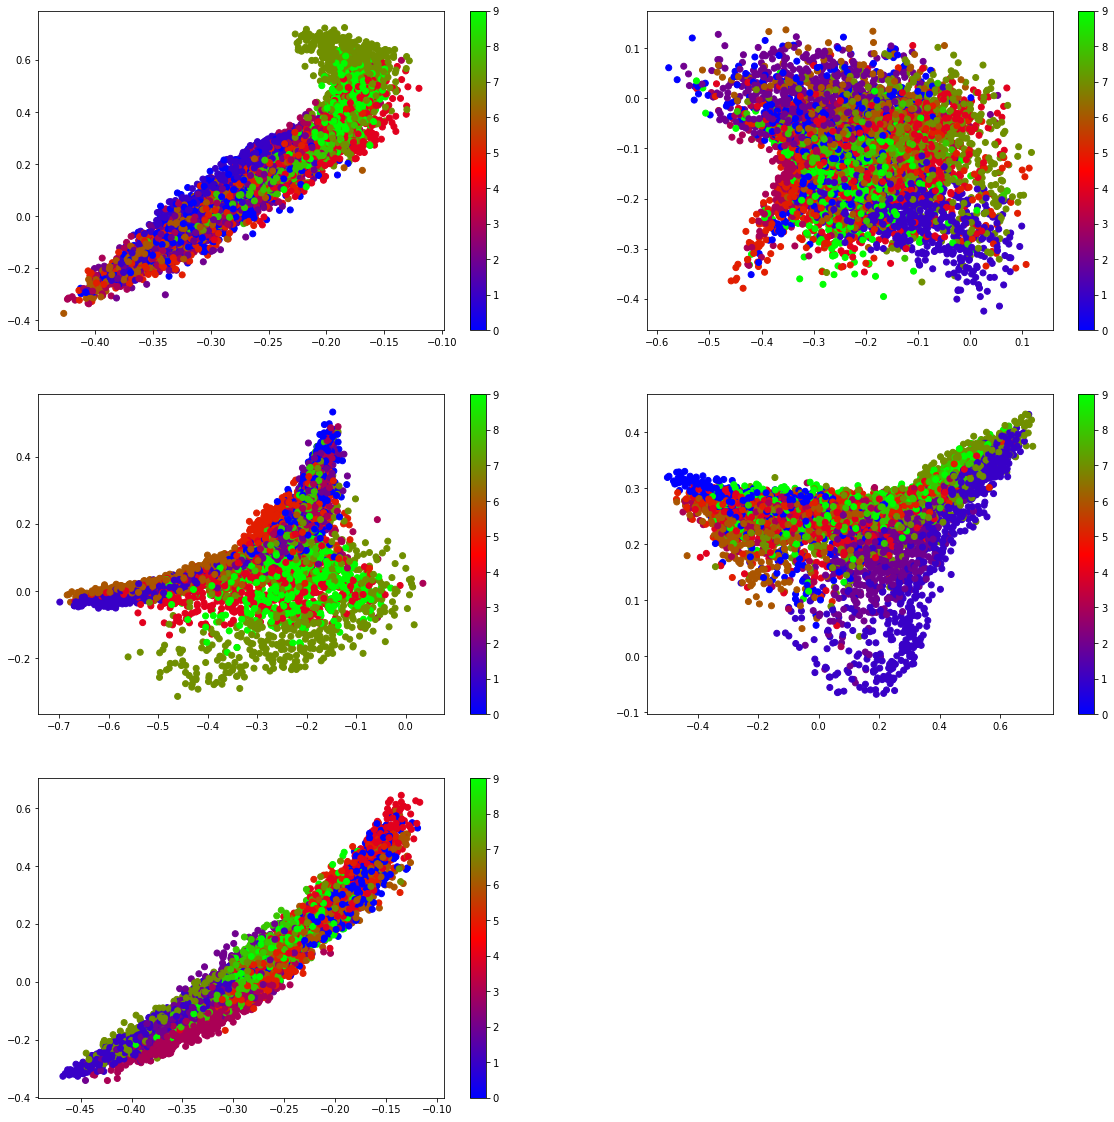

In [496]:
plot_2d_latent_space(model_supervised, onehot_encoder, X_test, y_test)

In [480]:
images_from_standard_normal_flat, resps = model_supervised.predict_X_resps(X=X_train[0:64,:], x_dim=X_train.shape[1], hard=True)
images_from_standard_normal = images_from_standard_normal_flat.reshape((64,28,28)).shape
resps_rounded = np.around(resps, decimals=3)
resps_1, resps_2, resps_3, resps_4, resps_5 = np.split(resps, axis=1, indices_or_sections=discrete_dim)
resps.shape

(64, 50)

In [481]:
resps_1.shape, resps_2.shape

((64, 10), (64, 10))

In [482]:
resps_1_label = np.argmax(resps_1, axis=1)

In [483]:
resps_2_label = np.argmax(resps_2, axis=1)

In [484]:
resps_1_label

array([0, 9, 9, 9, 8, 0, 9, 8, 8, 9, 9, 0, 0, 7, 9, 8, 9, 8, 0, 0, 8, 9,
       8, 7, 8, 8, 0, 0, 8, 9, 0, 0, 0, 0, 8, 0, 0, 8, 9, 0, 9, 9, 8, 0,
       0, 9, 9, 8, 8, 8, 0, 8, 9, 9, 0, 0, 8, 0, 8, 8, 9, 8, 9, 9])

In [485]:
np.around(resps[0:10,:], decimals=3)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

In [486]:
np.around(softmax(resps[0:2,:]/1.0), decimals=3)

array([[0.046, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017,
        0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017,
        0.017, 0.046, 0.017, 0.017, 0.017, 0.046, 0.017, 0.017, 0.017,
        0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017,
        0.017, 0.017, 0.017, 0.046, 0.017, 0.017, 0.046, 0.017, 0.017,
        0.017, 0.017, 0.017, 0.017, 0.017],
       [0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017,
        0.046, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017,
        0.017, 0.046, 0.017, 0.017, 0.017, 0.017, 0.017, 0.046, 0.017,
        0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017,
        0.017, 0.017, 0.017, 0.046, 0.017, 0.046, 0.017, 0.017, 0.017,
        0.017, 0.017, 0.017, 0.017, 0.017]], dtype=float32)

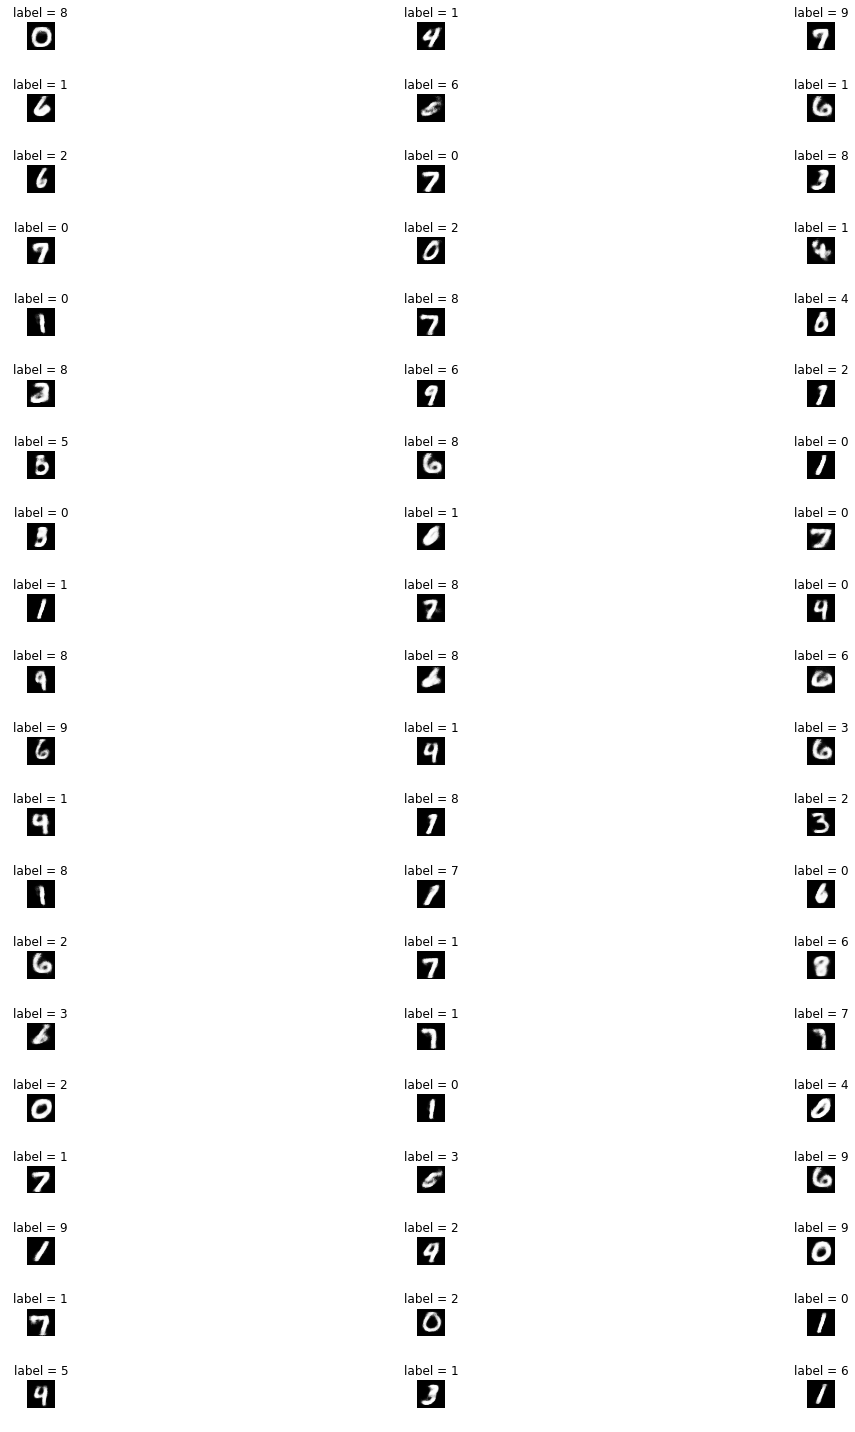

In [487]:
plt.figure(figsize=(20,20))
plot_many_images(images_from_standard_normal_flat, resps_label, rows=20)

In [488]:
def predict(X_train,y_train, input_dim):
    batch_sz=64
    all_rows = np.empty([0, input_dim], dtype = float)
    n_batches = len(X_train) // batch_sz
    for j in range(n_batches):
        batch_x = X_train[j * batch_sz:(j + 1) * batch_sz]
        batch_y = y_train[j * batch_sz:(j + 1) * batch_sz]

        _, resps = model_supervised.predict_X_resps(X=batch_x, x_dim=X_train.shape[1], hard=True)
        #print(resps.shape)
        #resps_label = np.argmax(resps, axis=1)
        all_rows = np.append(all_rows, resps, axis=0)
    
    return all_rows

In [489]:
resps_train = predict(X_train,y_train, discrete_dim*10)

In [490]:
resps_test = predict(X_test,y_test, discrete_dim*10)

In [491]:
resps_train.shape, y_train[:62976,:].shape

((62976, 50), (62976, 10))

In [492]:
resps_test.shape, y_test[:6976,:].shape

((6976, 50), (6976, 10))

In [493]:
resps_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [494]:
simple_nn = SimpleNN([discrete_dim*10,512, 256, 128, 10])
simple_nn.fit(resps_train, y_train[:62976,:], resps_test, y_test[:6976,:], epochs=10)

Train accuracy: 63.83%
Test accuracy: 63.6%


In [30]:
calculate_accuracy_np(all_rows, y_train[:62976,:])

0.1384813262195122

In [31]:
np.argmax(all_rows, axis=1)

array([4, 6, 4, ..., 5, 1, 4])

In [32]:
reduced_data = pd.DataFrame({
    'in': np.argmax(y_train[:62976,:], axis=1),
    'out': np.argmax(all_rows, axis=1)
})
reduced_data.head()

,in,out
0,4,4
1,8,6
2,0,4
3,2,3
4,9,5


In [36]:
def score_for_class(true_class):
    stats = reduced_data[reduced_data['in']==true_class]
    scores = (stats.groupby(['out']).count()/len(stats)).values
    chosen_class = np.argmax(scores)
    return scores, chosen_class

In [44]:
score_for_class(6)

(array([[8.09716599e-04],
        [9.08987854e-01],
        [8.85829960e-02],
        [1.13360324e-03],
        [3.23886640e-04],
        [1.61943320e-04]]), 1)

In [494]:
stats = reduced_data[reduced_data['in']==5]
len(stats)

5696

In [490]:
scores = (stats.groupby(['out']).count()/len(stats)).values
scores

array([[0.01404494],
       [0.02018961],
       [0.18627107],
       [0.26369382],
       [0.16011236],
       [0.0854986 ],
       [0.00351124],
       [0.00719803],
       [0.0193118 ],
       [0.24016854]])

In [492]:
scores[np.argmax(scores)]

array([0.26369382])

In [466]:
stats = reduced_data[reduced_data['in']==4]
np.argmax(np.bincount(stats['out']))

2

In [47]:
model_supervised.encode2(X_test)[0].shape

(7000, 2)

In [48]:
resp = model_supervised.encode_to_discrete(X_test)

In [49]:
resp.shape

(7000, 10)

In [50]:
resp[1]

array([0.00000000e+00, 0.00000000e+00, 3.36717547e-24, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.45503545e-33, 0.00000000e+00], dtype=float32)

In [86]:
resp_train = model_supervised.encode_to_discrete(X_train)
resp_test = model_supervised.encode_to_discrete(X_test)

In [87]:
resp_train.shape, resp_test.shape, X_train.shape

((63000, 10), (7000, 10), (63000, 784))

In [88]:
np.isnan(resp_train).sum()

0

In [89]:
np.isnan(resp_test).sum()

0

In [90]:
np.argwhere(np.isnan(resp_train))

array([], shape=(0, 2), dtype=int64)

In [79]:
# resp_train[34097,:] = np.zeros(10)
# resp_train[40214,:] = np.zeros(10)

Train accuracy: 78.41%
Test accuracy: 78.83%


In [97]:
# simple_nn = SimpleNN([784,512,10])
# simple_nn.fit(X_train, y_train, X_test, y_test)

In [98]:
simple_nn = SimpleNN([10,512, 256, 128, 10])
simple_nn.fit(resp_train, y_train, resp_test, y_test, epochs=10)

KeyboardInterrupt: 

In [83]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf.fit(resp_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [84]:
rf_predict = clf.predict(resp_test)

In [85]:
calculate_accuracy_np(y_pred=rf_predict, y_true=y_test)

0.6584285714285715